In [1]:
%load_ext autoreload
%autoreload 2 

In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from skopt.space import Real, Integer
import gc
from sklearn.utils import resample
import os

from sparse_features import search_params, evaluate_models, evaluate_pca_components, evaluate_umap_components, transform_features,select_features_by_score, calculate_sparsity, df_to_sparse

# Book Recommendation Dataset (№2)

## data to train,val,test (i-iii)

In [3]:
ratings = pd.read_csv('data/Ratings.csv')
users = pd.read_csv('data/Users.csv')

In [4]:
# Получаем уникальные ID пользователей и книг
unique_user_ids = ratings['User-ID'].unique()
unique_isbns = ratings['ISBN'].unique()

# Создаем словари для отображения: 'ID' -> 'индекс'
user_id_map = {id: i for i, id in enumerate(unique_user_ids)}
isbn_map = {id: i for i, id in enumerate(unique_isbns)}

# Применяем эти отображения к DataFrame, чтобы получить столбцы с индексами
ratings['user_idx'] = ratings['User-ID'].map(user_id_map)
ratings['book_idx'] = ratings['ISBN'].map(isbn_map)

In [5]:
data = np.ones(ratings.shape[0], dtype=np.int8)

row_indices = ratings['user_idx'].values
col_indices = ratings['book_idx'].values

matrix_shape = (len(unique_user_ids), len(unique_isbns))

sparse_user_book_matrix = csr_matrix((data, (row_indices, col_indices)), shape=matrix_shape)


In [6]:
users_with_age = users.set_index('User-ID')
age_target = users_with_age.loc[unique_user_ids]['Age']
age_target_filled = age_target.fillna(age_target.median())

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(
    sparse_user_book_matrix,
    age_target_filled,
    test_size=0.3,
    random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42
)

## Обучение моделей на изначальных признаках (iv)

In [ ]:
param_space_tree = {
    'max_depth': Integer(5, 40),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20)
}

In [35]:
tree_best_params, _, _ = search_params(
    X_train, y_train, X_valid, y_valid, 
    estimator=DecisionTreeRegressor(random_state=42), 
    params=param_space_tree, 
    n_iter=10
)

Поиск завершен. Оценка топ-3 моделей на валидационной выборке...
  Ранг 1 (CV): CV MSE=129.3383, Valid MSE=129.0370, Параметры: OrderedDict([('max_depth', 34), ('min_samples_leaf', 18), ('min_samples_split', 7)])
  Ранг 2 (CV): CV MSE=129.3762, Valid MSE=128.7067, Параметры: OrderedDict([('max_depth', 31), ('min_samples_leaf', 19), ('min_samples_split', 5)])
  Ранг 3 (CV): CV MSE=129.4336, Valid MSE=128.9749, Параметры: OrderedDict([('max_depth', 38), ('min_samples_leaf', 14), ('min_samples_split', 18)])

--- Лучшая модель (по оценке на валидации) ---
  Параметры: OrderedDict([('max_depth', 31), ('min_samples_leaf', 19), ('min_samples_split', 5)])
  CV MSE: 129.3762
  Validation MSE: 128.7067



In [51]:
models_to_test = [
    LinearRegression(n_jobs=-1),
    RandomForestRegressor(random_state=42, n_estimators=100,
    **tree_best_params, )
]

In [52]:
evaluate_models(
    X_train, y_train, X_valid, y_valid, 
    models_to_test,
    X_test, y_test
)

--- Оценка модели: LinearRegression ---
--- Оценка модели: RandomForestRegressor ---

--- Сводная таблица результатов (метрика: mean_squared_error) ---


,LinearRegression,RandomForestRegressor
Fit Time (s),38.138,1514.859
Train,23.949,127.377
Validation,658.863,128.126
Test,584.728,128.957


## Получение факторов (v)

In [8]:
X_train.shape

(73698, 340556)

In [8]:
X_tr_sel, X_val_sel, X_te_sel = select_features_by_score(X_train, y_train, X_valid, X_test, 5)

--- Шаг 1: Оценка всех признаков ---
Всего признаков с ненулевой оценкой: 274619
Признаков с оценкой > 5: 14049

--- Шаг 3: Создание финального селектора с k=14049 и трансформация данных ---
Трансформация завершена.
Новая форма X_train: (73698, 14049)


Для достижения 95% объясненной дисперсии требуется: 2257 компонент.


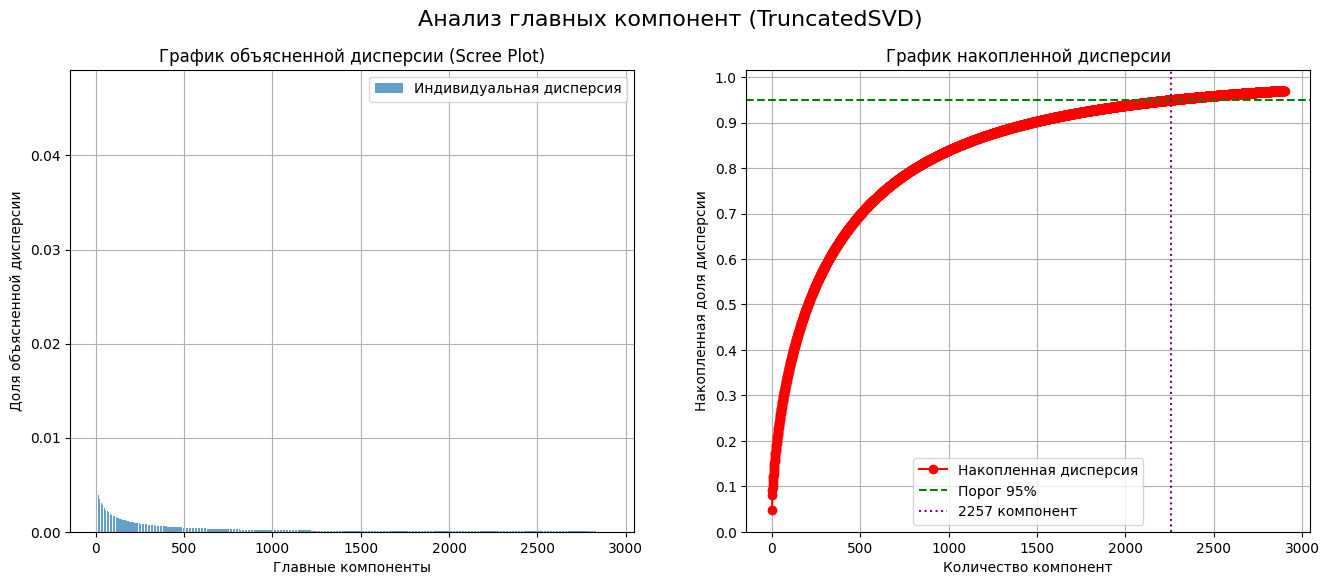

In [12]:
pca_n = evaluate_pca_components(X_tr_sel, range(100, 3000, 100))

Оценка оптимального числа компонент для UMAP...
  Тестирование с n_components = 10...
  Тестирование с n_components = 20...
  Тестирование с n_components = 30...
  Тестирование с n_components = 40...
  Тестирование с n_components = 50...
  Тестирование с n_components = 60...
  Тестирование с n_components = 70...
  Тестирование с n_components = 80...
  Тестирование с n_components = 90...
  Тестирование с n_components = 100...
  Тестирование с n_components = 110...
  Тестирование с n_components = 120...
  Тестирование с n_components = 130...
  Тестирование с n_components = 140...


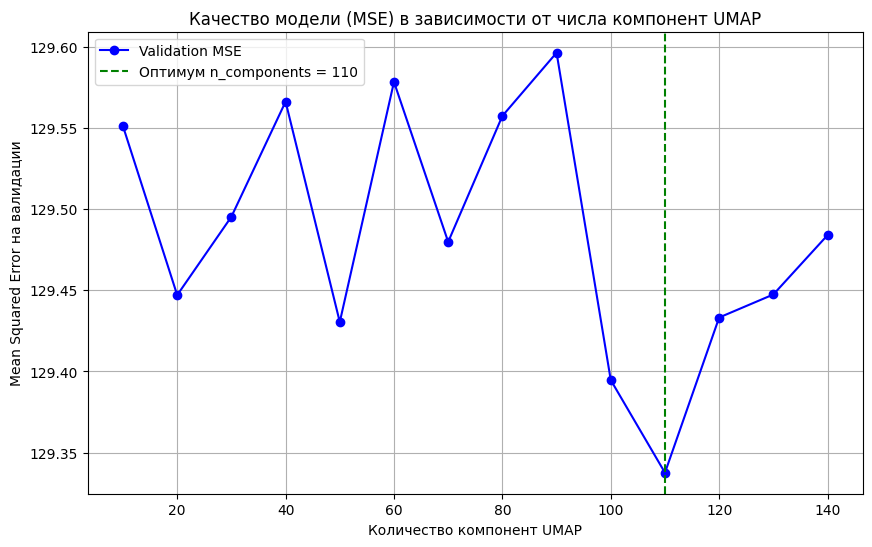

In [14]:
umap_n = evaluate_umap_components(X_tr_sel, y_train, X_val_sel, y_valid, range(10, 150, 10))

In [9]:
pca_n = 2257
umap_n = 110

In [10]:
X_train_pca, X_valid_pca, X_test_pca = transform_features(X_tr_sel, X_val_sel, X_te_sel, [y_train.index, y_valid.index, y_test.index], pca_n, "TruncatedSVD")
X_train_umap, X_valid_umap, X_test_umap = transform_features(X_tr_sel, X_val_sel, X_te_sel, [y_train.index, y_valid.index, y_test.index], umap_n, "umap")

--- Применение метода: TruncatedSVD с 2257 компонентами ---
Обучение модели на X_train...
Трансформация X_train, X_valid и X_test...
Трансформация завершена.
--- Применение метода: umap с 110 компонентами ---
Обучение модели на X_train...
Трансформация X_train, X_valid и X_test...
Трансформация завершена.


In [11]:
datasets_to_save = {
    'X_train_pca.csv': X_train_pca,
    'X_valid_pca.csv': X_valid_pca,
    'X_test_pca.csv': X_test_pca,
    'X_train_umap.csv': X_train_umap,
    'X_valid_umap.csv': X_valid_umap,
    'X_test_umap.csv': X_test_umap
}

In [14]:
for filename, df in datasets_to_save.items():
    filepath = os.path.join('data/sparse', filename)
    df.to_csv(filepath, index=True)

In [8]:
csv_files_to_load = [
    'X_train_pca.csv', 'X_valid_pca.csv', 'X_test_pca.csv',
    'X_train_umap.csv', 'X_valid_umap.csv', 'X_test_umap.csv'
]
loaded_csv_datasets = {}

In [9]:
for filename in csv_files_to_load:
    filepath = os.path.join('data/sparse', filename)
    df = pd.read_csv(filepath, index_col=0)
    variable_name = filename.split('.')[0]
    loaded_csv_datasets[variable_name] = df

In [15]:
for df in loaded_csv_datasets:
    calculate_sparsity(loaded_csv_datasets[df], df)

--- Анализ разреженности X_train_pca ---
Форма DataFrame: (73698, 2257)
Всего элементов: 166,336,386
Элементов, близких к нулю (абс. значение < 1e-09): 120,671,850
Процент разреженности (доля нулей): 72.55%

ВЫВОД: Умеренная разреженность. Преобразование в 'sparse' может дать небольшой выигрыш.
--- Анализ разреженности X_valid_pca ---
Форма DataFrame: (15792, 2257)
Всего элементов: 35,642,544
Элементов, близких к нулю (абс. значение < 1e-09): 26,266,262
Процент разреженности (доля нулей): 73.69%

ВЫВОД: Умеренная разреженность. Преобразование в 'sparse' может дать небольшой выигрыш.
--- Анализ разреженности X_test_pca ---
Форма DataFrame: (15793, 2257)
Всего элементов: 35,644,801
Элементов, близких к нулю (абс. значение < 1e-09): 26,101,353
Процент разреженности (доля нулей): 73.23%

ВЫВОД: Умеренная разреженность. Преобразование в 'sparse' может дать небольшой выигрыш.
--- Анализ разреженности X_train_umap ---
Форма DataFrame: (73698, 110)
Всего элементов: 8,106,780
Элементов, близких

In [10]:
X_train_pca, X_valid_pca, X_test_pca = df_to_sparse(loaded_csv_datasets["X_train_pca"]), df_to_sparse(loaded_csv_datasets["X_valid_pca"]), df_to_sparse(loaded_csv_datasets["X_test_pca"])

In [13]:
X_train_pca

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 45015453 stored elements and shape (73698, 2257)>

In [14]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 799900 stored elements and shape (73698, 340556)>

## Обучение моделей на полученных факторах (vi)

### PCA

In [ ]:
models_to_test = [
    LinearRegression(n_jobs=-1)
]

In [16]:
evaluate_models(
    X_train_pca, y_train, X_valid_pca, y_valid, 
    models_to_test,
    X_test_pca, y_test
)

--- Оценка модели: LinearRegression ---

--- Сводная таблица результатов (метрика: mean_squared_error) ---


,LinearRegression
Fit Time (s),25.574
Train,111.761
Validation,138.813
Test,135.730


**Качество для линейной регрессии улучшилось, время обучения слегка меньше. Однако для случайного леса время обучения слишком большое в связи с тем, что данные стали плотнее несмотря на меньшее колво переменных**

### UMAP

In [17]:
param_space_tree = {
    'max_depth': Integer(5, 40),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20)
}

In [18]:
tree_best_params, _, _ = search_params(
    loaded_csv_datasets["X_train_umap"], y_train,loaded_csv_datasets["X_valid_umap"], y_valid, 
    estimator=DecisionTreeRegressor(random_state=42), 
    params=param_space_tree, 
    n_iter=10
)

Поиск завершен. Оценка топ-3 моделей на валидационной выборке...
  Ранг 1 (CV): CV MSE=129.3818, Valid MSE=129.2230, Параметры: OrderedDict([('max_depth', 5), ('min_samples_leaf', 17), ('min_samples_split', 15)])
  Ранг 2 (CV): CV MSE=140.4817, Valid MSE=140.1528, Параметры: OrderedDict([('max_depth', 19), ('min_samples_leaf', 15), ('min_samples_split', 19)])
  Ранг 3 (CV): CV MSE=141.0480, Valid MSE=140.7447, Параметры: OrderedDict([('max_depth', 21), ('min_samples_leaf', 18), ('min_samples_split', 4)])

--- Лучшая модель (по оценке на валидации) ---
  Параметры: OrderedDict([('max_depth', 5), ('min_samples_leaf', 17), ('min_samples_split', 15)])
  CV MSE: 129.3818
  Validation MSE: 129.2230



In [19]:
param_space_rf = {
    'n_estimators': Integer(20, 80)
}

In [20]:
rf_best_params, rf_cv_mse, rf_valid_mse = search_params(
    loaded_csv_datasets["X_train_umap"], y_train, loaded_csv_datasets["X_valid_umap"], y_valid, 
    estimator=RandomForestRegressor(random_state=42,
    **tree_best_params), 
    params=param_space_rf, 
    n_iter=5,
    cv = 3
)

Поиск завершен. Оценка топ-3 моделей на валидационной выборке...
  Ранг 1 (CV): CV MSE=129.0799, Valid MSE=128.9702, Параметры: OrderedDict([('n_estimators', 69)])
  Ранг 2 (CV): CV MSE=129.0800, Valid MSE=128.9710, Параметры: OrderedDict([('n_estimators', 70)])
  Ранг 3 (CV): CV MSE=129.0807, Valid MSE=128.9692, Параметры: OrderedDict([('n_estimators', 68)])

--- Лучшая модель (по оценке на валидации) ---
  Параметры: OrderedDict([('n_estimators', 68)])
  CV MSE: 129.0807
  Validation MSE: 128.9692



In [21]:
models_to_test = [
    LinearRegression(n_jobs=-1),
    RandomForestRegressor(random_state=42,
    **tree_best_params, **rf_best_params)
]

In [22]:
evaluate_models(
    loaded_csv_datasets["X_train_umap"], y_train, loaded_csv_datasets["X_valid_umap"], y_valid, 
    models_to_test,
    loaded_csv_datasets["X_test_umap"], y_test
)

--- Оценка модели: LinearRegression ---
--- Оценка модели: RandomForestRegressor ---

--- Сводная таблица результатов (метрика: mean_squared_error) ---


,LinearRegression,RandomForestRegressor
Fit Time (s),3.543,317.615
Train,128.948,128.160
Validation,129.290,128.969
Test,130.231,129.974


**Качество для линейной регрессии улучшилось, для случайного леса осталось таким же, однако длительность обучения уменьшилась в 5 раз**